## Predicting Precision-Marketing Effectiveness in Banking

This project aims to predict the effectiveness of precision-marketing for clients to purchase a long-term investment product (e.g., certificate of deposit, CD) at a financial institution. The data is derived from Migueis et al. (2017, doi: 10.1007/s11628-016-0332-3). The dataset consists of about 30,000 labeled customers and variables such as profession, marital status, education, loan status, and more seen below. The labels are whether the customers were receptive to a specific marketing campagne, and the goals are to predict future client receptiveness, as well as creating a client profile that will be receptive to such CD product.

Below, the data is loaded out of a github repo, and then subjected to a quick EDA showcasing the feature distributions as well as correlation matrices. Following that, decision tree models are used to create the predictive model. Firstly, a single decision tree is used, followed by another single tree with respective variables excluded (e.g., duration, pdays). The duration features stands for the amount the phone call took, and the pdays stands for the amount of days since the last call. Lastly, a random forest model is used to compare a bagged solution to a single tree. Additionally, SHAP values are utilized in order to explain the random forest model and also build said customer profile.

### Loading Libraries and Data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
import numpy as np
import shap
import random

In [2]:
#Load data
cc = pd.read_csv('https://raw.githubusercontent.com/lucasweyrich958/Banking_Deposit_Classification/refs/heads/main/Marketing_Dataset.csv')

#Glimpse into dataset
cc.info() 
cc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32950 entries, 0 to 32949
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          32950 non-null  int64 
 1   job          32950 non-null  object
 2   marital      32950 non-null  object
 3   education    32950 non-null  object
 4   default      32950 non-null  object
 5   housing      32950 non-null  object
 6   loan         32950 non-null  object
 7   contact      32950 non-null  object
 8   month        32950 non-null  object
 9   day_of_week  32950 non-null  object
 10  duration     32950 non-null  int64 
 11  campaign     32950 non-null  int64 
 12  pdays        32950 non-null  int64 
 13  previous     32950 non-null  int64 
 14  poutcome     32950 non-null  object
 15  y            32950 non-null  object
dtypes: int64(5), object(11)
memory usage: 4.0+ MB


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


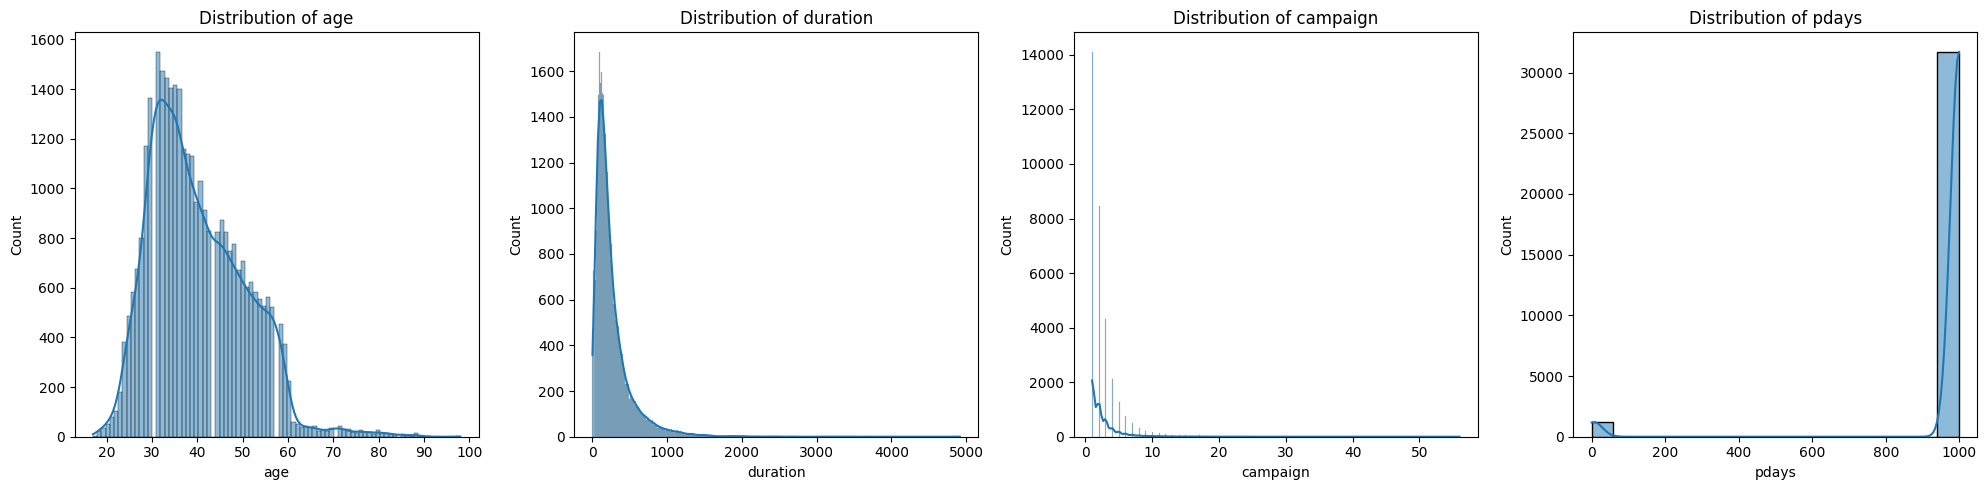

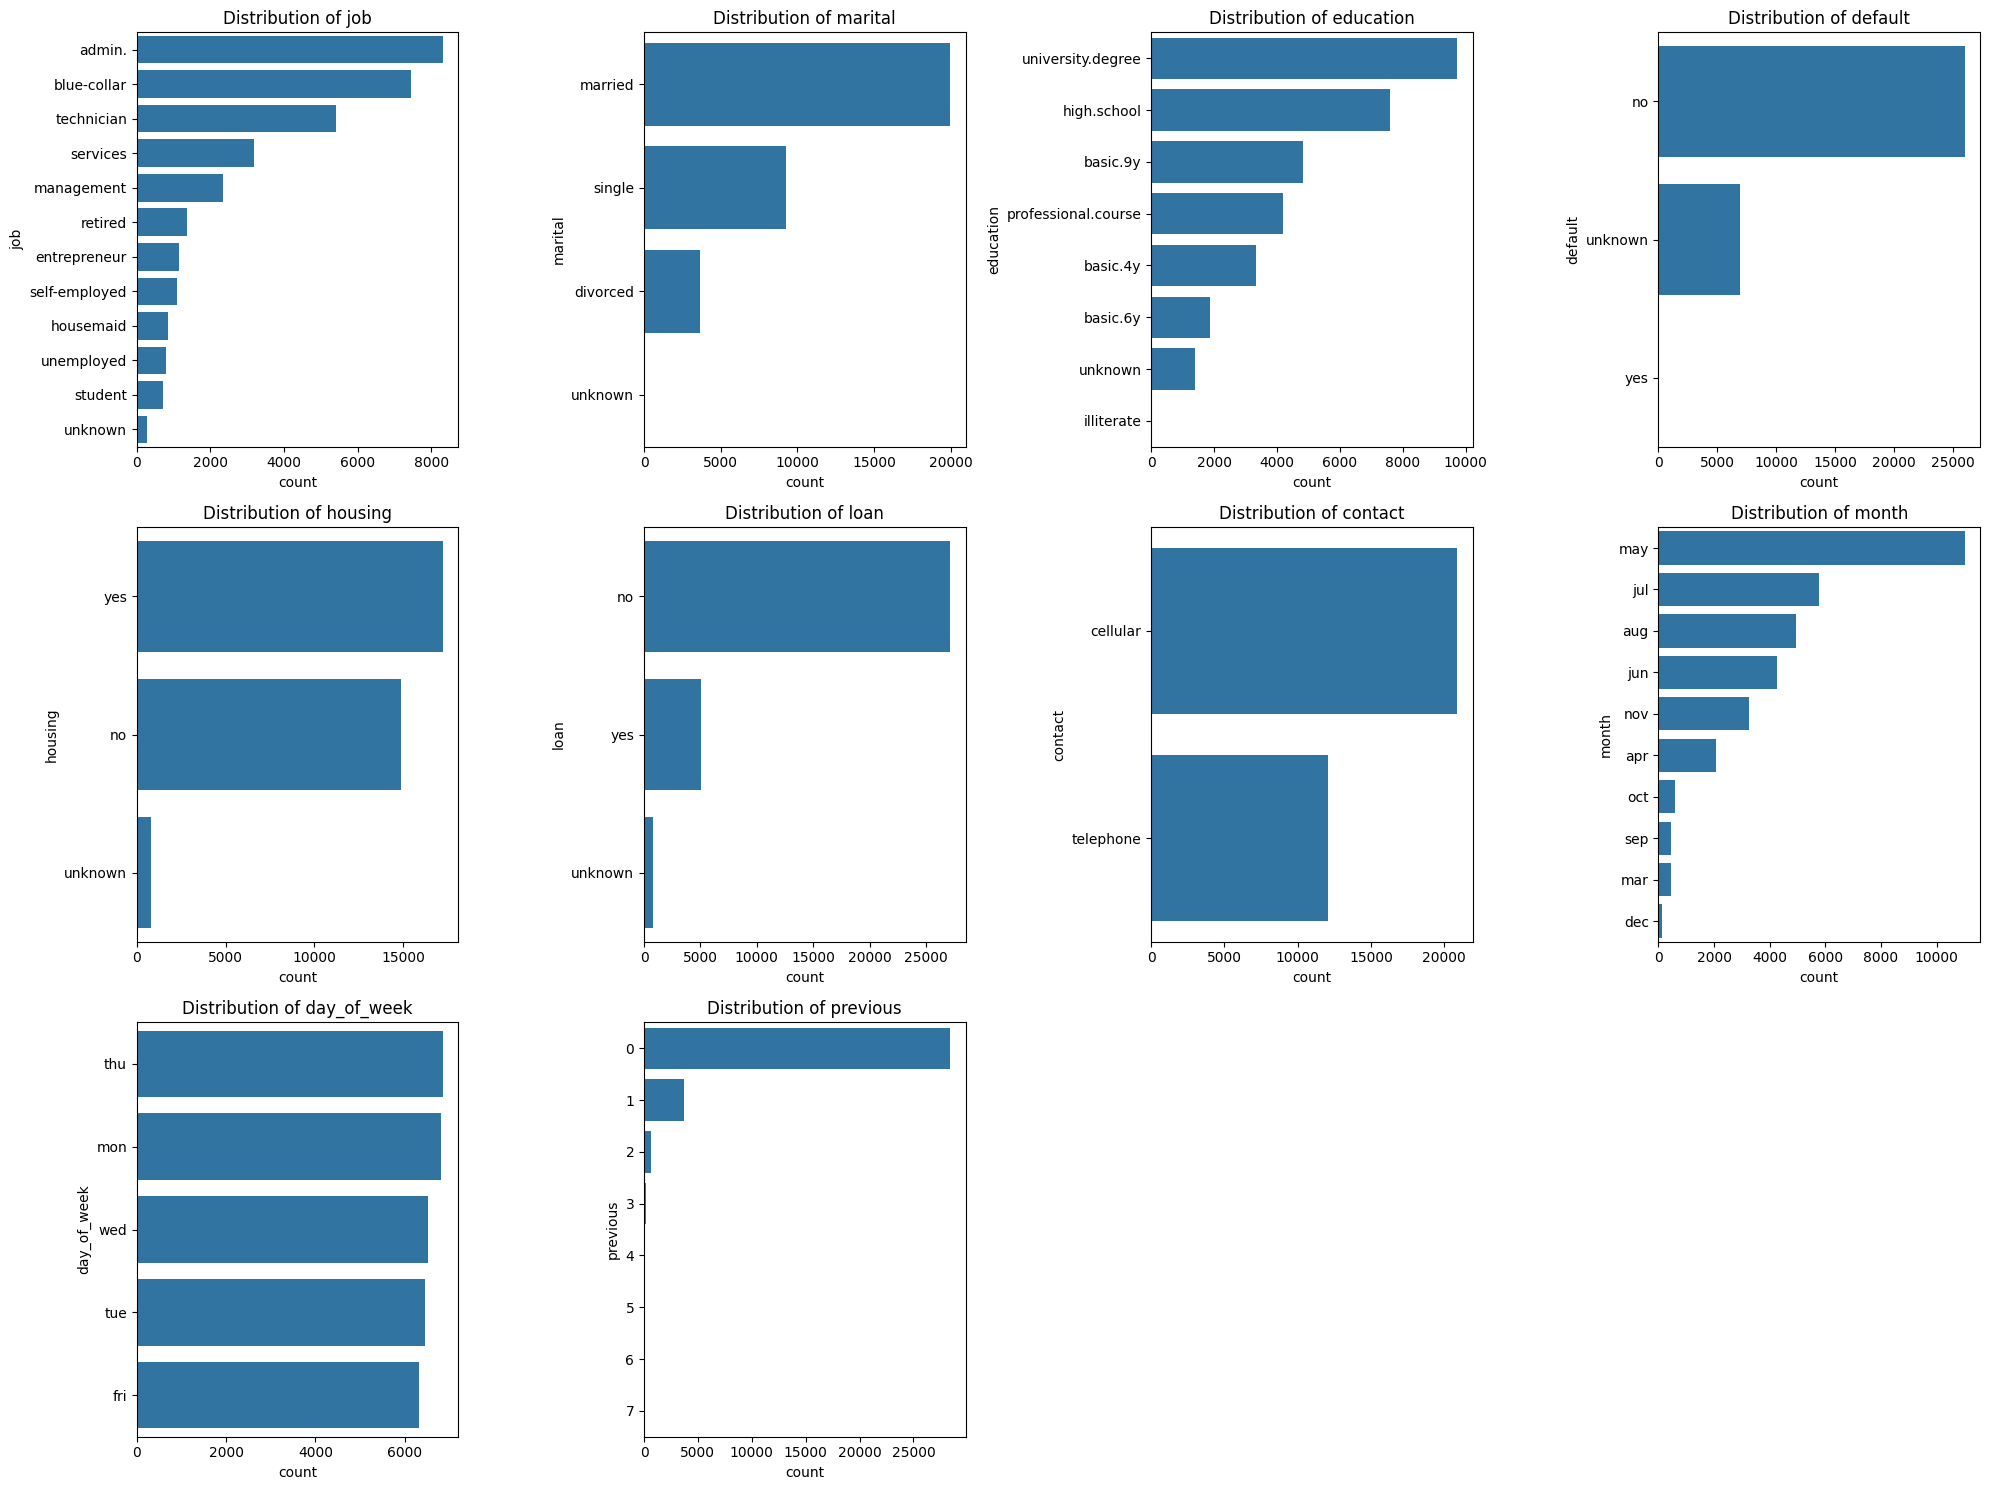

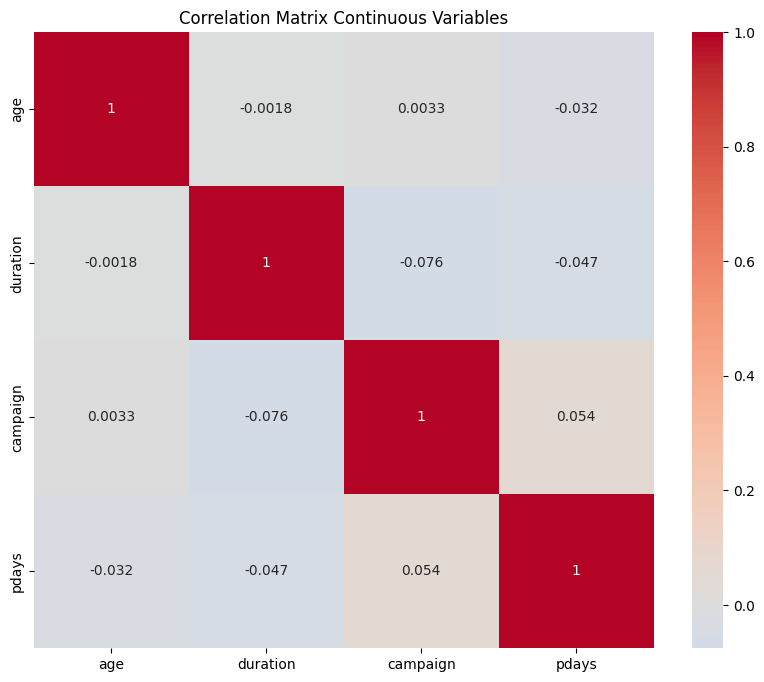

In [3]:
#Select continuous variables
continuous_vars = ['age', 'duration', 'campaign', 'pdays']
n_continuous = len(continuous_vars)
rows_continuous = (n_continuous + 3) // 4  #determine the number of rows needed

#Plot distributions of continuous variables
fig, axes = plt.subplots(rows_continuous, 4, figsize=(20, 5 * rows_continuous))
axes = axes.flatten()
for i, var in enumerate(continuous_vars):
    sns.histplot(cc[var], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_continuous, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Plot distributions for categorical variables
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous']
n_categorical = len(categorical_vars)
rows_categorical = (n_categorical + 3) // 4  #determine the number of rows needed

fig, axes = plt.subplots(rows_categorical, 4, figsize=(20, 5 * rows_categorical))
axes = axes.flatten()
for i, var in enumerate(categorical_vars):
    sns.countplot(y=cc[var], ax=axes[i], order=cc[var].value_counts().index)
    axes[i].set_title(f'Distribution of {var}')
for i in range(n_categorical, len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

#Correlation for continuous variables
corr_cont = cc[continuous_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cont, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Continuous Variables')
plt.show()


### Single Decision Tree

In [4]:
random.seed(958) #Set seed

#Encode categorical variables
label_encoders = {}
for column in cc.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    cc[column] = label_encoders[column].fit_transform(cc[column])

#Split dataset into features and target variable
X = cc.drop('y', axis=1)
y = cc['y']

#Split data into train and test sets using 70/30 allocation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Hyperparameter Tuning using Grid Search
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
} #Using more standard values

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=5, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

#Select best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

#Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)


Best hyperparameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}


DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Best Model - Accuracy: 0.91
Best Model - Precision: 0.64
Best Model - AUC: 0.89


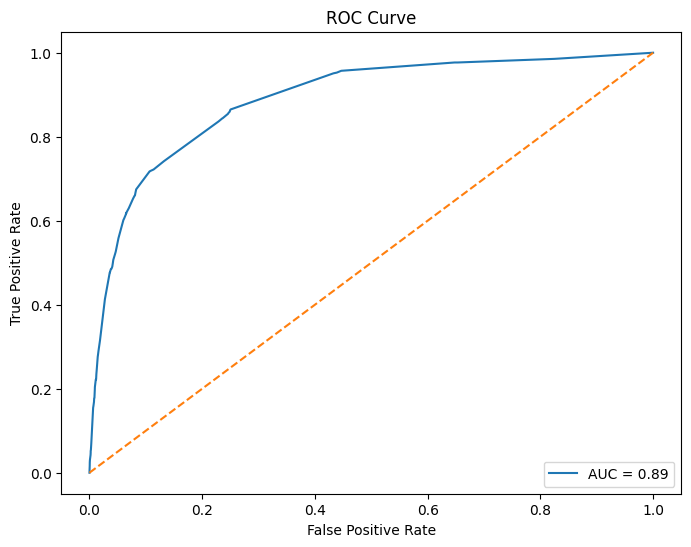

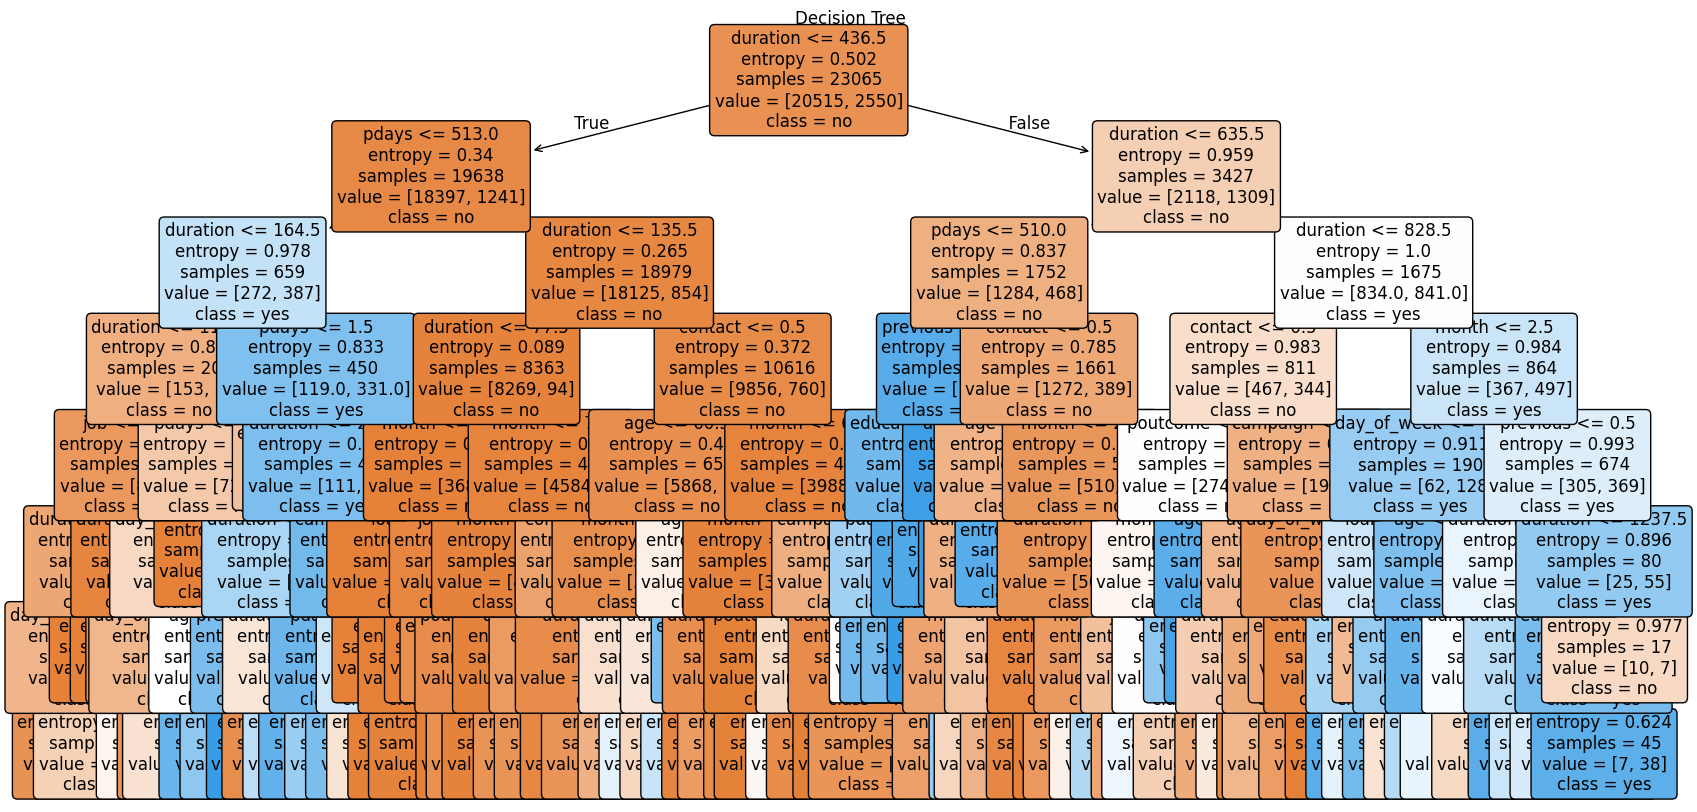

In [5]:
#Testing the set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

#Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

best_model_results = {"Accuracy": accuracy, "Precision": precision, "AUC": auc}

print(f"Best Model - Accuracy: {accuracy:.2f}")
print(f"Best Model - Precision: {precision:.2f}")
print(f"Best Model - AUC: {auc:.2f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Decision Tree')
plt.show()

### Single Decision Tree (Reduced)

In [6]:
random.seed(958)
#Dropping duration and pdays features
X_reduced = X.drop(['duration', 'pdays'], axis=1)

#Split the data again with the reduced dataset
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

#Train the reduced model with the same hyperparameters
custom_model = DecisionTreeClassifier(**best_params, random_state=42)
custom_model.fit(X_train_reduced, y_train_reduced)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=10,
                       random_state=42)

Custom Model - Accuracy: 0.89
Custom Model - Precision: 0.60
Custom Model - AUC: 0.73


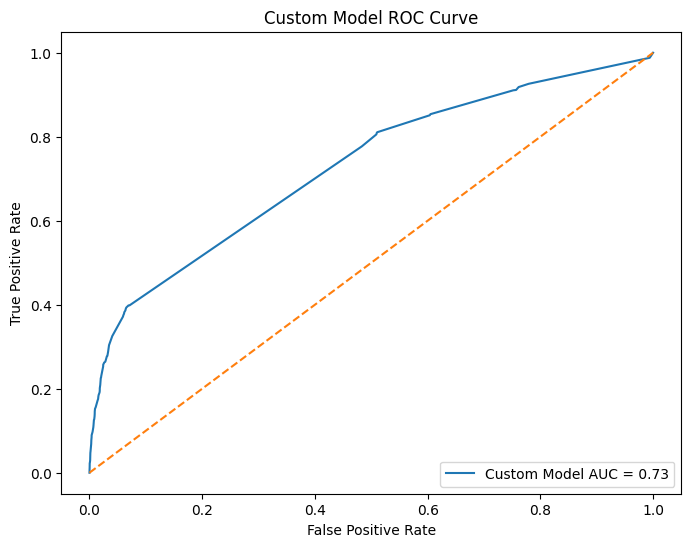

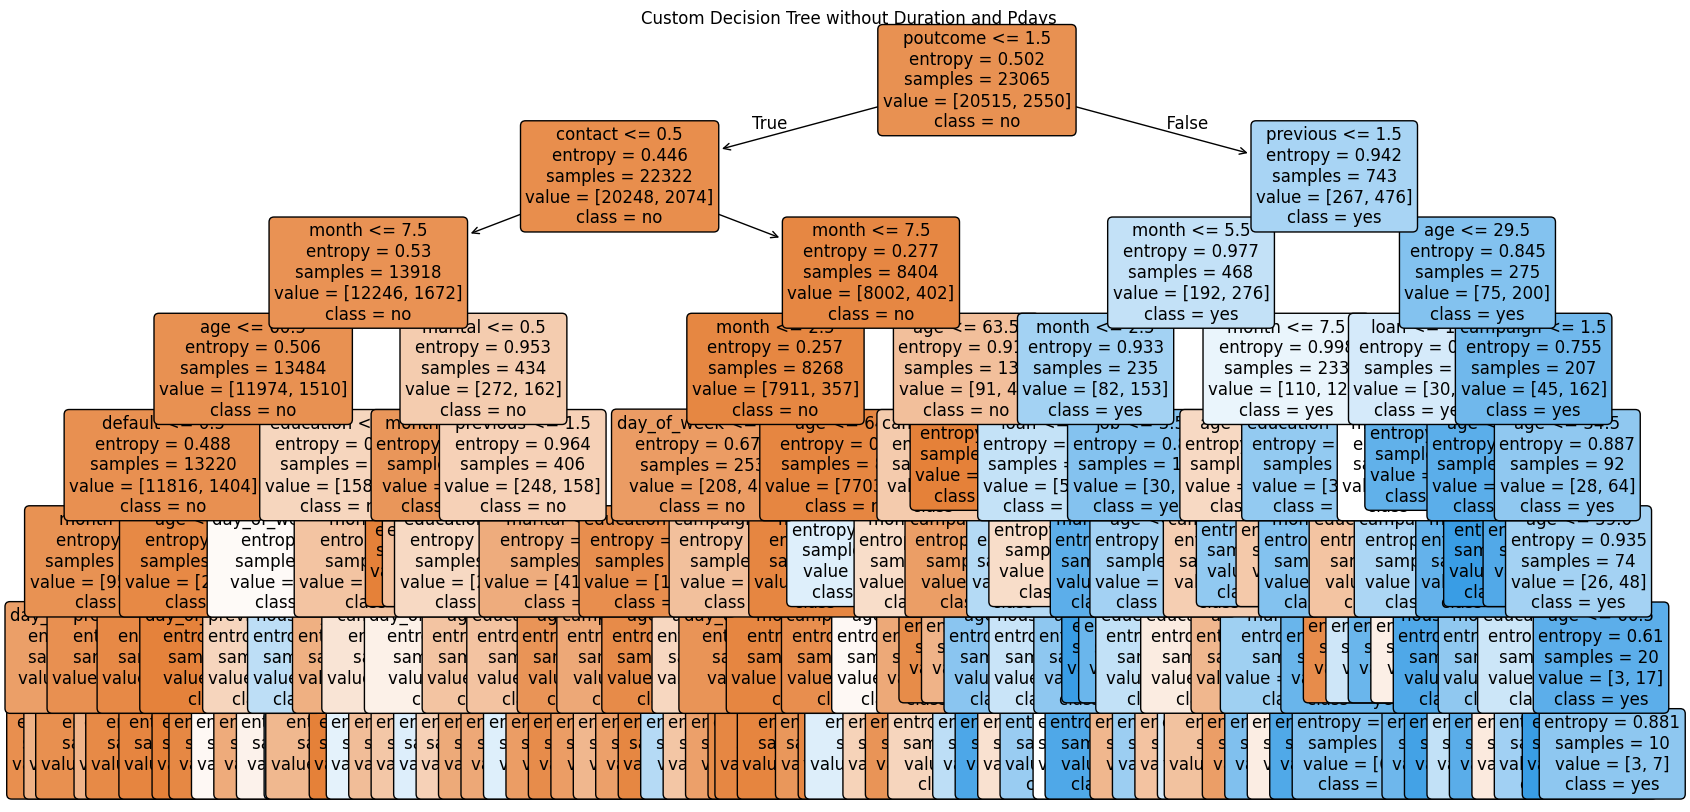

In [7]:
#Test reduced model
y_pred_custom = custom_model.predict(X_test_reduced)
y_proba_custom = custom_model.predict_proba(X_test_reduced)[:, 1]

#Calculate metrics for the custom model
accuracy_custom = accuracy_score(y_test_reduced, y_pred_custom)
precision_custom = precision_score(y_test_reduced, y_pred_custom)
auc_custom = roc_auc_score(y_test_reduced, y_proba_custom)

custom_model_results = {"Accuracy": accuracy_custom, "Precision": precision_custom, "AUC": auc_custom}

print(f"Custom Model - Accuracy: {accuracy_custom:.2f}")
print(f"Custom Model - Precision: {precision_custom:.2f}")
print(f"Custom Model - AUC: {auc_custom:.2f}")

#Plot ROC Curve for the custom model
fpr_custom, tpr_custom, _ = roc_curve(y_test_reduced, y_proba_custom)
plt.figure(figsize=(8, 6))
plt.plot(fpr_custom, tpr_custom, label=f'Custom Model AUC = {auc_custom:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Custom Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

#Plot custom model tree
plt.figure(figsize=(20, 10))
plot_tree(custom_model, filled=True, feature_names=X_reduced.columns, class_names=['no', 'yes'], rounded=True, fontsize=12)
plt.title('Custom Decision Tree without Duration and Pdays')
plt.show()

### Random Forest Model

Random Forest Model - Accuracy: 0.90
Random Forest Model - Precision: 0.65
Random Forest Model - AUC: 0.92


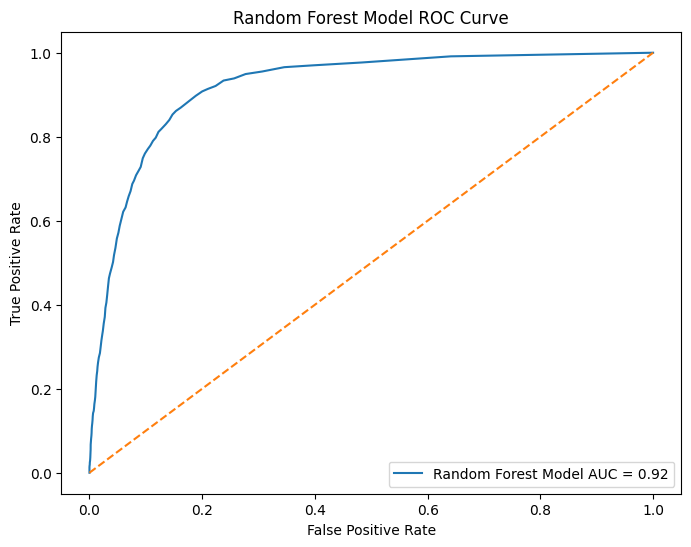

In [8]:
random.seed(958)
#Running Random Forest classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

#Evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#Calculate metrics for the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

rf_model_results = {"Accuracy": accuracy_rf, "Precision": precision_rf, "AUC": auc_rf}

print(f"Random Forest Model - Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest Model - Precision: {precision_rf:.2f}")
print(f"Random Forest Model - AUC: {auc_rf:.2f}")

#Plot ROC Curve for the Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest Model AUC = {auc_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model Comparison

In [9]:
#Compare the performance of the best model and the custom model
comparison_df = pd.DataFrame([best_model_results, custom_model_results, rf_model_results], index=['Best Model', 'Custom Model', 'Random Forest Model'])
print(comparison_df)

                     Accuracy  Precision       AUC
Best Model           0.906727   0.638249  0.888354
Custom Model         0.889833   0.604585  0.728071
Random Forest Model  0.903591   0.648649  0.919086


### Random Forest Explanations (SHAP Values)

In [44]:
#Clalculate SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

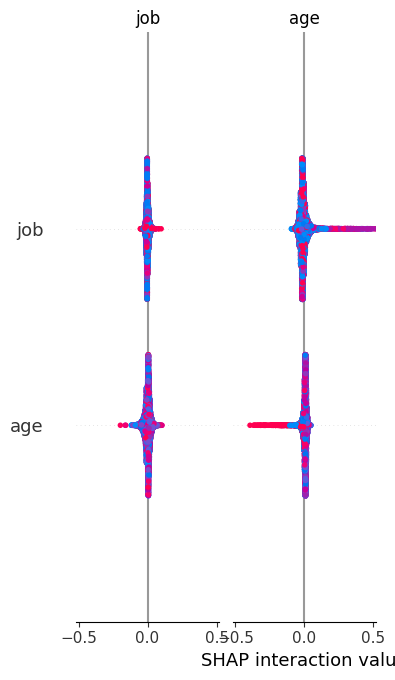

In [ ]:
X_display, y_display = shap.datasets.adult(display=True)
#SHAP summary plot
shap.summary_plot(shap_values, X)

# SHAP force plot for a random sample
shap.initjs()
#shap.force_plot(explainer.expected_value[0], shap_values[:1000, :], X.iloc[:100, :])
shap.force_plot(explainer.expected_value, shap_values.values[1, :], X_display.iloc[0, :])

### Essay Deliverable
This project aimed to predict whether a client would purchase a long-term certificate of deposit financial product based on precision-marketing strategy. The idea is to predict future client receptiveness based on previously collected data from marketing campagnes. 

The above decision tree models showcase the logic behind a decision tree. With its splitting into two new branches at variables where there is low error, it is able to reach good accuracies. The single decision tree is even able to outperform the bagged random forest, at least in terms of accuracy (looking at the area under the curve, the random forest actually outperforms, showing better accuracy and precision). Nevertheless, the above analysis also shows the reliance on few strong features. When removing the two most important features, the performance of the single decision tree decreases, certainly. Additionally, several disadvantages are seen that are described in the blog post. For example that the decision tree repeats patterns in muliple branches. Looking at the original single tree, it becomes apparent that the variable 'duration' is split on several times. The danger here is that it may lead to overfitting, and it also simply relies too heavily on only one feature. To make up for this, the random forest is able to bag the average of many single trees, even ones where duration may not be split on that much. Nevertheless, looking at the SHAP values, it becomes apparent that duration is simply an important feature.
When removing the two most important features, based on early split, the performance not only decreases, but the tree also becomes smaller, generally. This may or may not be a good thing. Although in this case it is seemingly not good since all evaluation metrics decreased, especially the AUC.

Furthermore, this analysis also showcases the interpretability of decision trees and its bagged extensions. While a single decision tree can be traced easily, the bagged extension can be explained relatively intuitive using SHAP values. These values model feature importance, which is very suitable for production-level predictive models that need to be explained often. 

In sum, while both the single tree and the random forest would do well in production, the random forest will likely be more flexible, require a bit less maintenance over time (i.e., retraining), and will show better performance in predicting whether a client would invest into a CD based on precision-marketing.